# Feature engineering plan:
 - Education and Marital_Status features
 - Detecting and handling outliers:
    - transformations
    - The next step depends on the task.
 - adding new features.

In [55]:
# constant
RAW_DATA_CLEANED = "../data/preprocessed/cleaned/marketing_campaign.csv" 
Export_DATA_ENGINEERING = "../data/preprocessed/engineering/marketing_campaign.csv" 

In [56]:
import pandas as pd
import numpy as np 
from scipy import stats
import matplotlib.pyplot as plt


from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import FunctionTransformer, RobustScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline



from sklearn.preprocessing import StandardScaler, MinMaxScaler


# set the max columns to none
pd.set_option('display.max_columns', None)

In [57]:
data = pd.read_parquet(RAW_DATA_CLEANED)
data.head()

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
0,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1
1,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0
2,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0
3,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0
4,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0


### Education and Marital_Status


In [58]:
## Education and Marital_Status
# Education	Marital_Status with many destinct values
# (decision) what will we do with them ?
data.Marital_Status.value_counts()
# after understandig the situation of every one 
# merge YOLO, Absurd, Alone in single and let other



Marital_Status
Married     785
Together    509
Single      438
Divorced    214
Widow        70
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64

In [59]:
status_map = {
    'Alone': 'Single',
    'Absurd': 'Single',
    'YOLO': 'Single'
}

data.Marital_Status = data.Marital_Status.replace(status_map)
data.Marital_Status.value_counts()

Marital_Status
Married     785
Together    509
Single      445
Divorced    214
Widow        70
Name: count, dtype: int64

In [60]:
# education 
data.Education.value_counts() # i think no action needed

Education
Graduation    1016
PhD            440
Master         335
2n Cycle       183
Basic           49
Name: count, dtype: int64

## Detecting and handling outliers

Strategies:
 - Demographics features: drop them (in clean part)
 - other numeric features like MntFruits and Recency:
    - transformation.
    - the next step depend on the task or the question that we want to answer from the data.


> IMPORTANT NOTE: the stratege that we will use later is depend on the task or the question we want to answer.

> NOTE: here, we only care about detecting and try to decrease the impact of outliers. 

- univarite

In [61]:
# univarite
numerical_cols = ['Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
                  'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']

Q1 = data[numerical_cols].quantile(0.25)
Q3 = data[numerical_cols].quantile(0.75)
IQR = Q3 - Q1

# only very extreme values
thr = 1.5

((data[numerical_cols] < (Q1 - thr * IQR)) | (data[numerical_cols] > (Q3 + thr * IQR))).sum(axis=0)

Recency                  0
MntWines                32
MntFruits              221
MntMeatProducts        168
MntFishProducts        202
MntSweetProducts       219
MntGoldProds           184
NumDealsPurchases       74
NumWebPurchases          3
NumCatalogPurchases     19
NumStorePurchases        0
NumWebVisitsMonth        8
dtype: int64

In [62]:
# in every one
((data[numerical_cols] < (Q1 - thr * IQR)) | (data[numerical_cols] > (Q3 + thr * IQR))).sum(axis=0).sum()

1130

In [63]:
# if row has more than one true, will be catched only one time.
((data[numerical_cols] < (Q1 - thr * IQR)) | (data[numerical_cols] > (Q3 + thr * IQR))).any(axis=1).sum(axis=0)

636

- multivariate
    - Isolation Forest and LocalOutlierFactor : need strong domine knowledge with strong info about the process that the data was faced, to determine the contamination.
    - DBSCAN : to detect outliers in multivariate (may be just a cluster not an outliers)

In [64]:
df = data.copy()

In [65]:
# DBSCAN

# Prepare the data
X = df[numerical_cols]

# Standardize the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


# Function to find optimal epsilon
def find_epsilon(X, n_neighbors=5):
    neigh = NearestNeighbors(n_neighbors=n_neighbors)
    nbrs = neigh.fit(X)
    distances, indices = nbrs.kneighbors(X)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    return np.percentile(distances, 90)

# Find optimal epsilon
epsilon = find_epsilon(X_scaled)

# Apply DBSCAN
dbscan = DBSCAN(eps=epsilon, min_samples=5)
cluster_labels = dbscan.fit_predict(X_scaled)

# Add the cluster labels to the dataframe
df['cluster'] = cluster_labels

# Identify outliers (points labeled as -1 are considered noise/outliers)
df['is_outlier'] = (cluster_labels == -1).astype(int)

# Separate inliers and outliers
df_inliers = df[df['is_outlier'] == 0].drop(['cluster', 'is_outlier'], axis=1)
df_outliers = df[df['is_outlier'] == 1].drop(['cluster', 'is_outlier'], axis=1)

print(f"Number of outliers detected: {len(df_outliers)}")
print(f"Shape of dataset before removing outliers: {df.shape}")
print(f"Shape of dataset after removing outliers: {df_inliers.shape}")
print(f" percentage = {format((df_outliers.shape[0] / df.shape[0]),'.3f')}%")

Number of outliers detected: 338
Shape of dataset before removing outliers: (2023, 28)
Shape of dataset after removing outliers: (1685, 26)
 percentage = 0.167%


### distributions transformations (normalization).

In [66]:
# Define the transformations 
log_transformer = FunctionTransformer(np.log1p, validate=True)
robust_scaler = RobustScaler()
zscore_scaler = StandardScaler()
minMax = MinMaxScaler()

In [67]:
# Define the features for each transformation
log_features = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts',
                'MntSweetProducts', 'MntGoldProds','NumDealsPurchases', 'NumWebPurchases',
                'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']

# ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5'] is a category features

In [68]:
# Create a ColumnTransformer to apply the transformations
# Combine log transformation and scaling in one ColumnTransformer
combined_transformer = ColumnTransformer(
    transformers=[
        ('log_and_scale', Pipeline([
            ('log', log_transformer),
 #           ('scaler', zscore_scaler)
        ]), log_features),
    ],
    remainder='passthrough'  # Leave other columns unchanged
)

# Apply the combined transformation to the dataset
data_transformed = combined_transformer.fit_transform(data)

# Convert the result back to a DataFrame for better readability
transformed_columns = log_features  
remaining_columns = [col for col in data.columns if col not in transformed_columns]
all_columns = transformed_columns + remaining_columns

data_transformed_df = pd.DataFrame(data_transformed, columns=all_columns)

# Display the first few rows of the transformed data
data_transformed_df.head()


,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
0,6.455199,4.488636,6.304449,5.153292,4.488636,4.488636,1.386294,2.197225,2.397895,1.609438,2.079442,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,0,0,0,0,0,0,1
1,2.484907,0.693147,1.94591,1.098612,0.693147,1.94591,1.098612,0.693147,0.693147,1.098612,1.791759,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,0,0,0,0,0,0,0
2,6.056784,3.912023,4.85203,4.718499,3.091042,3.7612,0.693147,2.197225,1.098612,2.397895,1.609438,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,0,0,0,0,0,0,0
3,2.484907,1.609438,3.044522,2.397895,1.386294,1.791759,1.098612,1.098612,0.0,1.609438,1.94591,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,0,0,0,0,0,0,0
4,5.159055,3.78419,4.779123,3.850148,3.332205,2.772589,1.791759,1.791759,1.386294,1.94591,1.791759,1981,PhD,Married,58293.0,1,0,2014-01-19,94,0,0,0,0,0,0,0


In [69]:
# convert types
for col in remaining_columns:
    data_transformed_df[col] = data_transformed_df[col].astype(data[col].dtype)

for col in transformed_columns:
    data_transformed_df[col] = data_transformed_df[col].astype(float)

data_transformed_df.dtypes

MntWines                      float64
MntFruits                     float64
MntMeatProducts               float64
MntFishProducts               float64
MntSweetProducts              float64
MntGoldProds                  float64
NumDealsPurchases             float64
NumWebPurchases               float64
NumCatalogPurchases           float64
NumStorePurchases             float64
NumWebVisitsMonth             float64
Year_Birth                      int64
Education                      object
Marital_Status                 object
Income                        float64
Kidhome                         int64
Teenhome                        int64
Dt_Customer            datetime64[ns]
Recency                         int64
AcceptedCmp3                    int64
AcceptedCmp4                    int64
AcceptedCmp5                    int64
AcceptedCmp1                    int64
AcceptedCmp2                    int64
Complain                        int64
Response                        int64
dtype: objec

In [70]:
# we want to have the zeros and their impact.
(data_transformed_df['MntFruits'] == 0.0 ).sum()

361

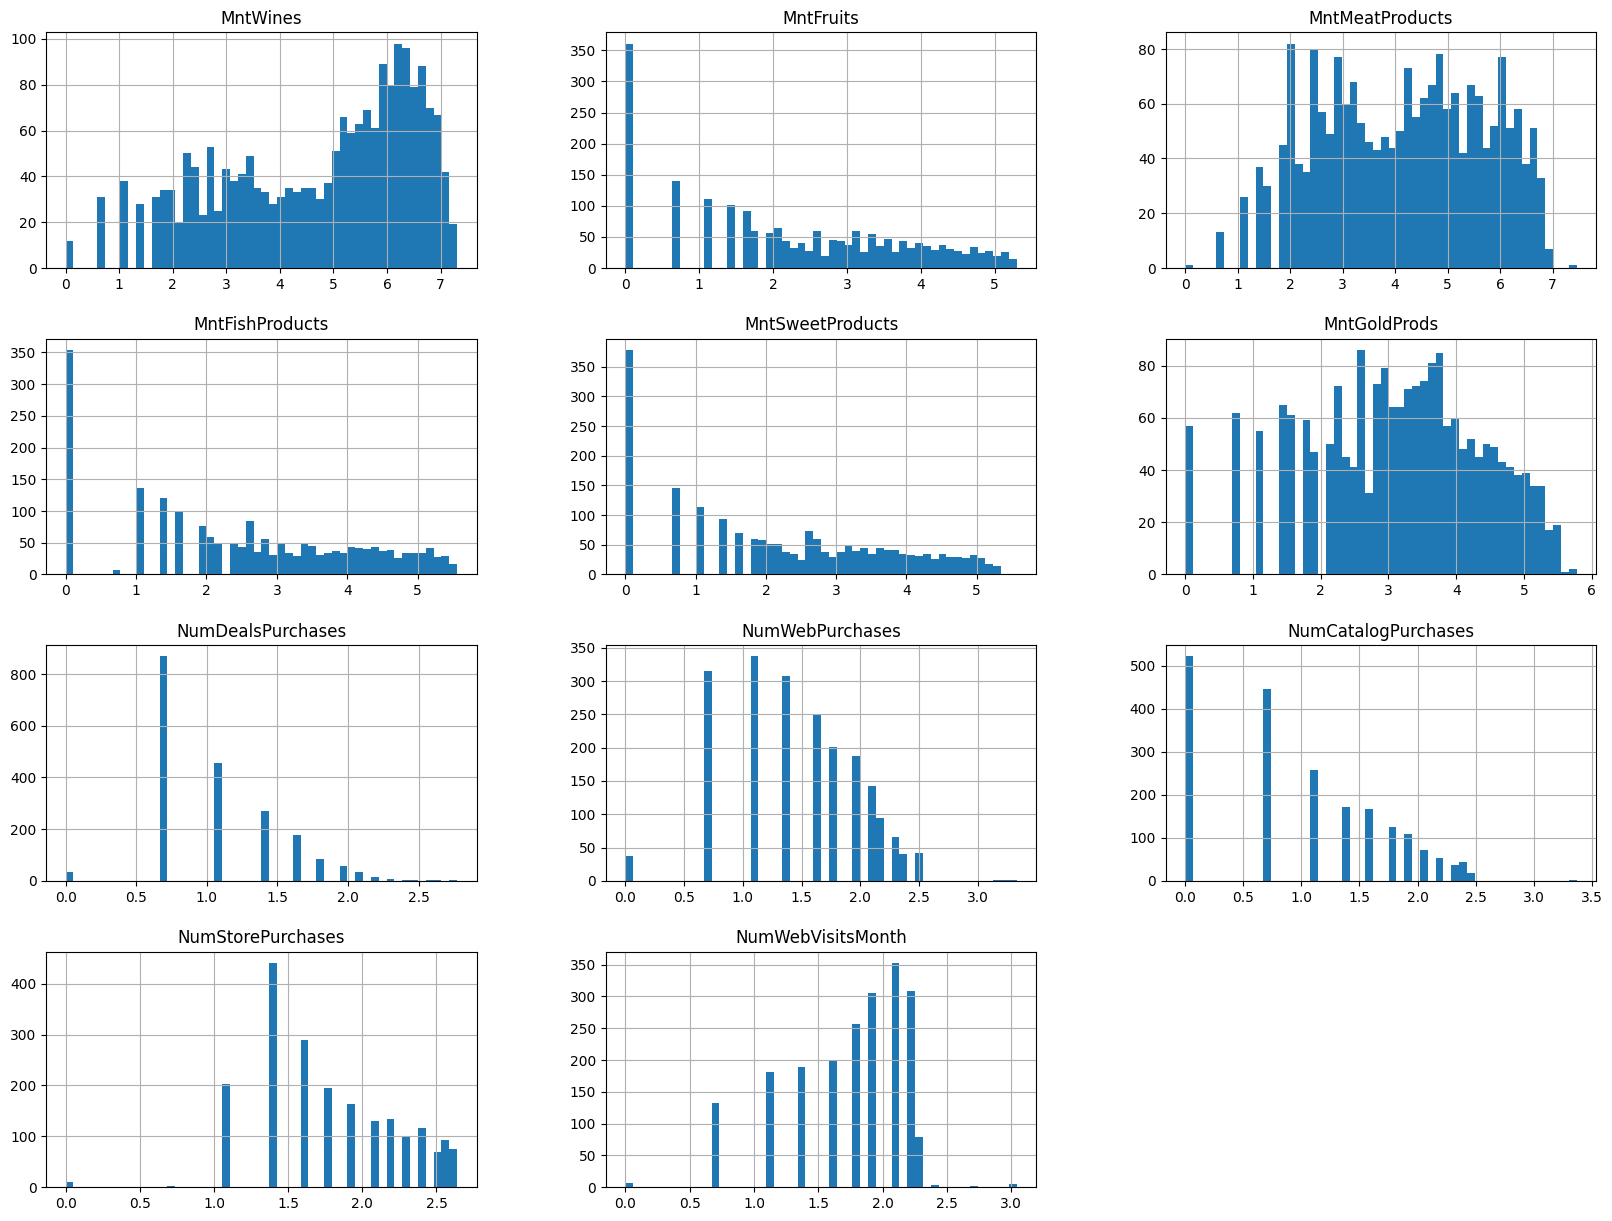

In [71]:
data_transformed_df[transformed_columns].hist(bins=50, figsize=(20, 15))
plt.show()

In [72]:
# copy the data

df = data_transformed_df.copy()

In [73]:
# univarite
numerical_cols = ['Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
                  'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']

Q1 = df[numerical_cols].quantile(0.25)
Q3 = df[numerical_cols].quantile(0.75)
IQR = Q3 - Q1

# only very extreme values
thr = 1.5

((df[numerical_cols] < (Q1 - thr * IQR)) | (df[numerical_cols] > (Q3 + thr * IQR))).sum(axis=0)

Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases      15
NumWebPurchases         2
NumCatalogPurchases     0
NumStorePurchases      10
NumWebVisitsMonth       6
dtype: int64

In [74]:
# DBSCAN


# Prepare the data
X = df[numerical_cols]

# Standardize the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


# Function to find optimal epsilon
def find_epsilon(X, n_neighbors=5):
    neigh = NearestNeighbors(n_neighbors=n_neighbors)
    nbrs = neigh.fit(X)
    distances, indices = nbrs.kneighbors(X)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    return np.percentile(distances, 90)

# Find optimal epsilon
epsilon = find_epsilon(X_scaled)

# Apply DBSCAN
dbscan = DBSCAN(eps=epsilon, min_samples=5)
cluster_labels = dbscan.fit_predict(X_scaled)

# Add the cluster labels to the dataframe
df['cluster'] = cluster_labels

# Identify outliers (points labeled as -1 are considered noise/outliers)
df['is_outlier'] = (cluster_labels == -1).astype(int)

# Separate inliers and outliers
df_inliers = df[df['is_outlier'] == 0].drop(['cluster', 'is_outlier'], axis=1)
df_outliers = df[df['is_outlier'] == 1].drop(['cluster', 'is_outlier'], axis=1)

print(f"Number of outliers detected: {len(df_outliers)}")
print(f"Shape of dataset before removing outliers: {df.shape}")
print(f"Shape of dataset after removing outliers: {df_inliers.shape}")
print(f" percentage = {format((df_outliers.shape[0] / df.shape[0]),'.3f')}%")

Number of outliers detected: 325
Shape of dataset before removing outliers: (2023, 28)
Shape of dataset after removing outliers: (1698, 26)
 percentage = 0.161%


### add features

In [75]:
# add more features
# every group of features is important, depend on the situation and the task

df = data_transformed_df

# Calculating age
df['Age'] = max(df.Dt_Customer).year - df['Year_Birth']
df.drop(['Year_Birth'],axis=1,inplace=True)

df['Customer_Tenure'] = ((max(df.Dt_Customer) - df['Dt_Customer']).dt.days) + 1 # to avoid zeros.
df.drop(['Dt_Customer'],axis=1,inplace=True) # drop date, for now i will not use it further.


# Calculating total amount spent
product_cols = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
df['total_Spent'] = df[product_cols].sum(axis=1)

# Calculate total Purchases
purchases = ['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']
df['total_purchases'] = df[purchases].sum(axis=1)


# Combining children columns
df['Children'] = df['Kidhome'] + df['Teenhome']
df.drop(['Kidhome','Teenhome'],axis=1,inplace=True)



# Calculating income per person
df['Income_per_Person'] = df['Income'] / (2 + df['Children'])

# Counting campaign participation
campaign_cols = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5','Response']
df['Campaign_Participation'] = df[campaign_cols].sum(axis=1)

# Categorizing recency
df['Recency_Category'] = pd.cut(df['Recency'], bins=[0, 30, 60, 90, df['Recency'].max()], labels=['Very Recent', 'Recent', 'Not Recent', 'Long Time'])

# total spent on the time
df['total_spent_per_time'] = df['total_Spent'] / df['Customer_Tenure']

# total purchases on the time
df['total_purchases_per_time'] = df['total_purchases'] / df['Customer_Tenure']



In [76]:
df['Campaign_Participation'].value_counts()

Campaign_Participation
0    1459
1     345
2     130
3      47
4      33
5       9
Name: count, dtype: int64

In [77]:
df['Recency_Category'].value_counts()

Recency_Category
Very Recent    631
Not Recent     600
Recent         593
Long Time      173
Name: count, dtype: int64

In [78]:
print(df.shape)
df.columns

(2023, 32)


Index(['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts',
       'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases',
       'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
       'NumWebVisitsMonth', 'Education', 'Marital_Status', 'Income', 'Recency',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Response', 'Age', 'Customer_Tenure',
       'total_Spent', 'total_purchases', 'Children', 'Income_per_Person',
       'Campaign_Participation', 'Recency_Category', 'total_spent_per_time',
       'total_purchases_per_time'],
      dtype='object')

In [79]:
# save the dataframe
df.to_parquet(Export_DATA_ENGINEERING, index=False)